In [2]:
#ultima fecha de actualizacion del codigo = 06/06/20204 (aun no finalizado)

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from tqdm import tqdm

plt.style.use('bmh')

In [129]:
df = pd.read_csv('proyecto3_AST230_TNG300.txt', usecols = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), delimiter = ' ', names=['posx[kpc/h]','posy[kpc/h]','posz[kpc/h]','stellar_mass[Msun/h]','M_dm[Msun/h]','Flag_cen1_sat0','g-band[mag]','r-band[mag]','i-band[mag]','z-band[mag]','SFR[Msun/yr]'])
df

posx[kpc/h]  posy[kpc/h]  posz[kpc/h]  stellar_mass[Msun/h]  \
0         43.718811    48.813641   147.594955          5.309484e+12   
1         45.442272    51.850201   146.416504          2.536628e+12   
2         44.490761    49.091713   147.870575          5.736570e+11   
3         43.820786    50.939400   147.711044          2.390980e+11   
4         44.302578    49.630974   147.869492          2.205959e+11   
...             ...          ...          ...                   ...   
305061    79.326889   121.422234   192.697708          5.952345e+08   
305062    47.927986    90.139610   201.900421          6.228271e+08   
305063   124.532074    49.072762    26.317783          6.412762e+08   
305064    86.524483   159.833344     8.927037          6.798668e+08   
305065   196.138870   146.159637   189.601151          5.989823e+08   

        M_dm[Msun/h]  Flag_cen1_sat0  g-band[mag]  r-band[mag]  i-band[mag]  \
0       1.086091e+15             1.0   -25.628429   -26.373409   -26.728613   
1       3.100674e+14             0.0   -24.891636   -25.636240   -25.990240   
2       8.386031e+12             0.0   -23.062399   -23.858458   -24.239382   
3       4.709129e+12             0.0   -22.211082   -22.987967   -23.359406   
4       4.453074e+12             0.0   -22.103907   -22.881990   -23.252897   
...              ...             ...          ...          ...          ...   
305061  3.381930e+10             1.0   -16.398605   -17.053431   -17.354071   
305062  3.505416e+10             1.0   -16.338009   -17.011997   -17.325453   
305063  3.377947e+10             1.0   -16.153374   -16.861992   -17.195801   
305064  3.409814e+10             1.0   -16.172039   -16.865326   -17.191351   
305065  3.282344e+10             1.0   -16.308905   -16.980253   -17.291983   

        z-band[mag]  SFR[Msun/yr]  
0        -26.975189           0.0  
1        -26.236513           0.0  
2        -24.516970           0.0  
3        -23.624681           0.0  
4        -23.519327           0.0  
...             ...           ...  
305061   -17.537222           0.0  
305062   -17.519899           0.0  
305063   -17.416292           0.0  
305064   -17.400881           0.0  
305065   -17.488224           0.0  

[305066 rows x 11 columns]

In [130]:
#vemos que hay halos con masa de DM = 0, por lo tanto las eliminamos de toda la muestra
dm_mass = np.asarray(df['M_dm[Msun/h]'])
pos_dm_0 = np.where(dm_mass != 0)[0]
dm_mass = dm_mass[pos_dm_0]

#definir las variables con los datos
#posiciones

posx = np.asarray(df['posx[kpc/h]'])[pos_dm_0]
posy = np.asarray(df['posy[kpc/h]'])[pos_dm_0]
posz = np.asarray(df['posz[kpc/h]'])[pos_dm_0]

#propiedades
stellar_mass = np.asarray(df['stellar_mass[Msun/h]'])[pos_dm_0]
sfr = np.asarray(df['SFR[Msun/yr]'])[pos_dm_0]

#flag central o satelite
Flag_cen1_sat0 	= np.asarray(df['Flag_cen1_sat0'])[pos_dm_0]

#magnitudes absolutas en los filtros
g_band = np.asarray(df['g-band[mag]'])[pos_dm_0]
r_band = np.asarray(df['r-band[mag]'])[pos_dm_0]
i_band = np.asarray(df['i-band[mag]'])[pos_dm_0]
z_band = np.asarray(df['z-band[mag]'])[pos_dm_0]
#creamos g-r band
g_r_band = g_band - r_band

In [131]:
#primero estudamos la bimodalidad de las galaxias (azules:blue cloud y rojas:red sequence)
ssfr = sfr/stellar_mass #creamos la variable specific star formation que nos indicaria la tasa de formacion estelar normalizada a la masa estelar total en la galaxia

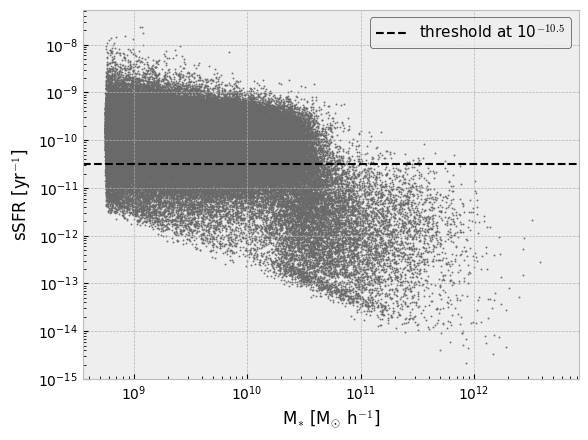

In [132]:
#graficamos la sSFR vs Stellar Mass
fig = plt.figure(figsize = (6.4,4.8))
ax = fig.subplots()

ax.set_xlabel(r'M$_{*}$ [M$_{\odot}$ h$^{-1}$]')
ax.set_ylabel(r'sSFR [yr$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(stellar_mass, ssfr, s = .8, color = 'dimgray', alpha = .8)
ax.axhline(10**(-10.5), lw = 1.5, ls = '--', color = 'black', label = 'threshold at 10$^{-10.5}$') #dashed line horizontal
ax.legend(fontsize = 11, edgecolor = (0,0,0,1), framealpha = .7)
plt.savefig('imagenes/preg1/ssfr_vs_m_star_1.png', dpi = 600)
plt.show()

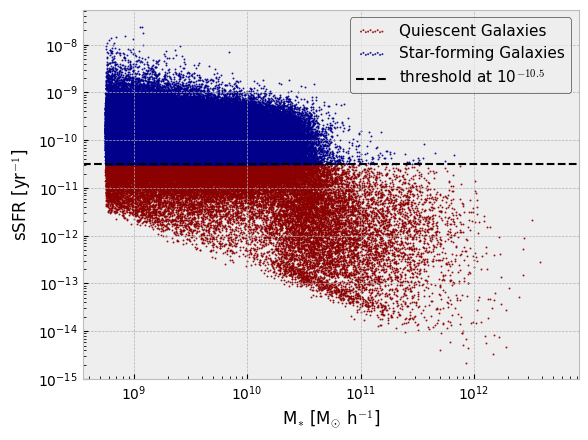

In [133]:
#ahora queremos separar entre las galaxias quiescent y las star-forming, por lo que buscamos sus posiciones en los arrays
pos_no_sforming = np.where(ssfr < 10**(-10.5))[0]
pos_sforming = np.where(ssfr > 10**(-10.5))[0]

#graficamos la sSFR vs Stellar Mass, pero ahora separado por las quiescent y las star-forming
fig = plt.figure(figsize = (6.4,4.8))
ax = fig.subplots()

ax.set_xlabel(r'M$_{*}$ [M$_{\odot}$ h$^{-1}$]')
ax.set_ylabel(r'sSFR [yr$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(stellar_mass[pos_no_sforming], ssfr[pos_no_sforming], s = .8, color = 'darkred', alpha = .8, label = 'Quiescent Galaxies')
ax.scatter(stellar_mass[pos_sforming], ssfr[pos_sforming], s = .8, color = 'darkblue', alpha = .8, label = 'Star-forming Galaxies')
ax.axhline(10**(-10.5), lw = 1.5, ls = '--', color = 'black', label = 'threshold at 10$^{-10.5}$') #dashed line horizontal
ax.legend(fontsize=11, edgecolor=(0,0,0,1), framealpha=.7, scatterpoints=10) 
plt.savefig('imagenes/preg1/ssfr_vs_m_star_2.png', dpi = 600)
plt.show()

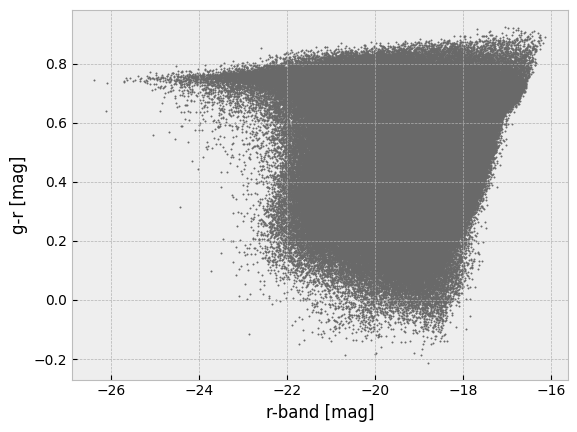

In [134]:
#ahora hacemos el color magnitud diagram
fig= plt.figure(figsize = (6.4,4.8))
ax = fig.subplots()

ax.set_xlabel(r'r-band [mag]')
ax.set_ylabel(r'g-r [mag]')

ax.scatter(r_band, g_r_band, s = .8, color = 'dimgray')

plt.savefig('imagenes/preg1/g-r_vs_r-band_1.png', dpi = 600)
plt.show()

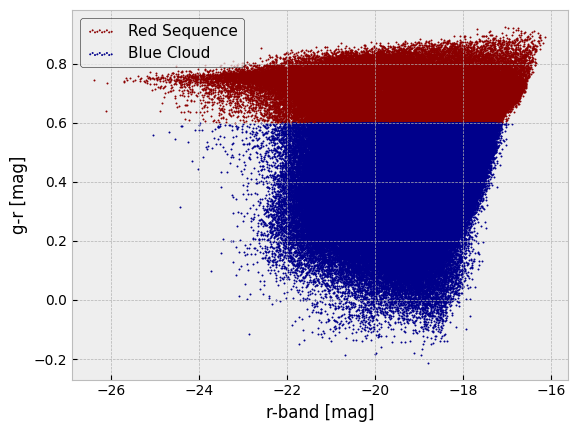

In [135]:
#elegimos el valor para galaxias en la red sequence como g-r > 0.6 (mencionar el corte de g-r > 0.6 (paper facu))
red_seq = np.where( g_r_band > 0.6 )[0]
blue_cloud = np.where( g_r_band <= 0.6 )[0]

#ahora hacemos el color magnitud diagram, pero pintado por los colores de las que se encontrarían en las red sequence y en la blue cloud (rojas y azules)
fig= plt.figure(figsize = (6.4,4.8))
ax = fig.subplots()

ax.set_xlabel(r'r-band [mag]')
ax.set_ylabel(r'g-r [mag]')

ax.scatter(r_band[red_seq], g_r_band[red_seq], s = .8, color = 'darkred', label = 'Red Sequence')
ax.scatter(r_band[blue_cloud], g_r_band[blue_cloud], s = .8, color = 'darkblue', label = 'Blue Cloud')

ax.legend(fontsize = 11, edgecolor = (0,0,0,1), framealpha = .7, loc = 'upper left', scatterpoints=10)
plt.savefig('imagenes/preg1/g-r_vs_r-band_2.png', dpi = 600)
plt.show()

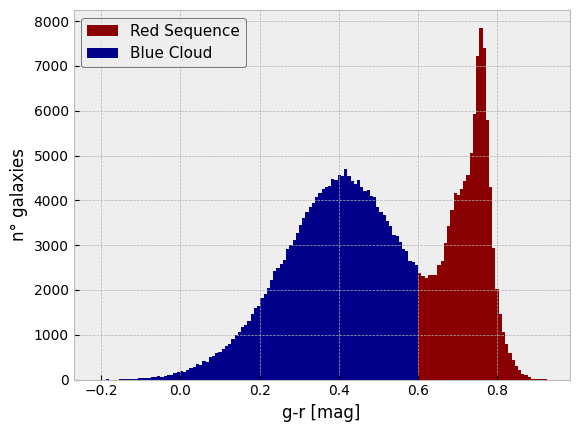

In [136]:
#histograma separado por galaxias en l ablue cloud y en la red sequence (g-r > 0.6)
fig= plt.figure(figsize = (6.4,4.8))
ax = fig.subplots()

ax.set_xlabel('g-r [mag]')
ax.set_ylabel('n° galaxies')

ax.hist(g_r_band[red_seq], color = 'darkred', bins = 40, label = 'Red Sequence')
ax.hist(g_r_band[blue_cloud], color = 'darkblue', bins = 100, label = 'Blue Cloud')

ax.legend(fontsize = 11, edgecolor = (0,0,0,1), framealpha = .7)

plt.savefig('imagenes/preg1/g-r_histogram.png', dpi = 600)
plt.show()

In [137]:
log_stellar_mass = np.log10(stellar_mass)

bins = np.linspace(min(log_stellar_mass), max(log_stellar_mass), 25)
list_red_frac = []
list_blue_frac = []
list_quiescent_frac = []
list_star_forming_frac = []
list_mitad_bin = []

for i in range(1, len(bins)):
    mass_min = bins[i-1]
    mass_max = bins[i]
    
    pos_red_gal = np.where((g_r_band >= 0.6) & (log_stellar_mass >= mass_min) & (log_stellar_mass < mass_max))[0]
    red_gal_per_bin = len(pos_red_gal)
    pos_gal_in_bin = np.where((log_stellar_mass >= mass_min) & (log_stellar_mass < mass_max))[0]
    gal_in_bin = len(pos_gal_in_bin)
    
    pos_blue_gal = np.where((g_r_band < 0.6) & (log_stellar_mass >= mass_min) & (log_stellar_mass < mass_max))[0]
    blue_gal_per_bin = len(pos_blue_gal)
    blue_frac = blue_gal_per_bin/gal_in_bin
    list_blue_frac.append(blue_frac)
    
    pos_quiescent_gal = np.where((ssfr < 10**(-10.5)) & (log_stellar_mass >= mass_min) & (log_stellar_mass < mass_max))[0]
    quiescent_gal_per_bin = len(pos_quiescent_gal)
    quiescent_frac = quiescent_gal_per_bin/gal_in_bin
    list_quiescent_frac.append(quiescent_frac)
    
    pos_star_forming_gal = np.where((ssfr > 10**(-10.5)) & (log_stellar_mass >= mass_min) & (log_stellar_mass < mass_max))[0]
    star_forming_gal_per_bin = len(pos_star_forming_gal)
    star_forming_frac = star_forming_gal_per_bin/gal_in_bin
    list_star_forming_frac.append(star_forming_frac)
    
    red_frac = red_gal_per_bin/gal_in_bin
    mitad_bin = (mass_min + mass_max)/2
    list_red_frac.append(red_frac)
    list_mitad_bin.append(mitad_bin)

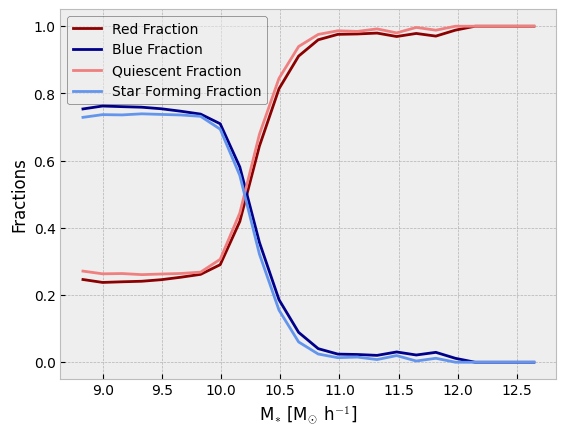

In [138]:
plt.plot(list_mitad_bin, list_red_frac, color = 'darkred', label = 'Red Fraction')
plt.plot(list_mitad_bin, list_blue_frac, color = 'darkblue', label = 'Blue Fraction')

plt.plot(list_mitad_bin, list_quiescent_frac, color = 'lightcoral', label = 'Quiescent Fraction')
plt.plot(list_mitad_bin, list_star_forming_frac, color = 'cornflowerblue', label = 'Star Forming Fraction')

plt.xlabel(r'M$_{*}$ [M$_{\odot}$ h$^{-1}$]')
plt.ylabel('Fractions')
plt.legend(edgecolor = (0,0,0,1), framealpha = .5)

plt.savefig('imagenes/preg1/fractions.png', dpi = 600)
plt.show()

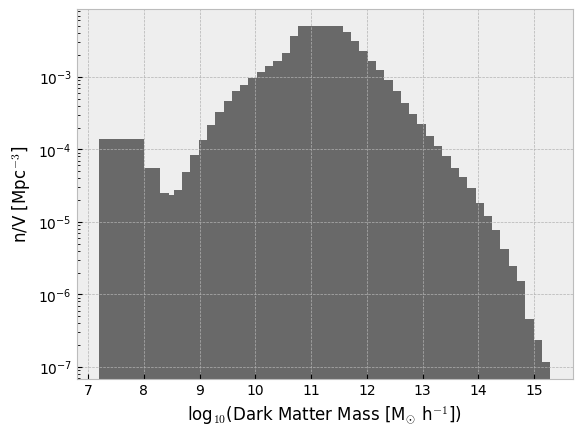

In [139]:
#Para ver la Halo Mass Function (number density en función de la masa de materia oscura)
vol_box_sim = 205**3 #volumen caja (si tomamos lo que dice el pdf: 205 [Mpc])
log_dm_mass = np.log10(dm_mass)

fig = plt.figure(figsize = (6.4,4.8))
ax = fig.subplots()

hist, bins = np.histogram(log_dm_mass, bins = 50)

ax.bar(bins[:-1], hist/vol_box_sim, color ='dimgray')

ax.set_xlabel(r'log$_{10}$(Dark Matter Mass [M$_{\odot}$ h$^{-1}$])')
ax.set_ylabel(r'n/V [Mpc$^{-3}$]')
ax.set_yscale('log')

plt.savefig('imagenes/preg2/Halo_Mass_Func_histogram.png', dpi = 600)
plt.show()

In [15]:
#posiciones para analizar la pendiente de la caida a masas menores
lower_masses = np.where((log_dm_mass < 11) & (log_dm_mass > 8.5))[0]

In [16]:
vol_box_sim = 205**3 #volumen caja (si tomamos lo que dice el pdf: 205 [Mpc])

log_dm_mass = np.log10(dm_mass[lower_masses]) #tomamos la masa en logaritmo (para luego ajustarlo así al curve_fit)

hist, bins = np.histogram(log_dm_mass, bins = 50) #creamos los histogramas para tener la cantidad de datos que tenemos y los dividimos por el volumen de la caja (según el lado entregado)
x_log = bins[:-1] #masas
y_log = np.log10(hist/vol_box_sim) #number_density

In [17]:
#funcion para ajustar con una ley de potencia 
def power_law(x, a, b):
    y = a*x + b
    return y

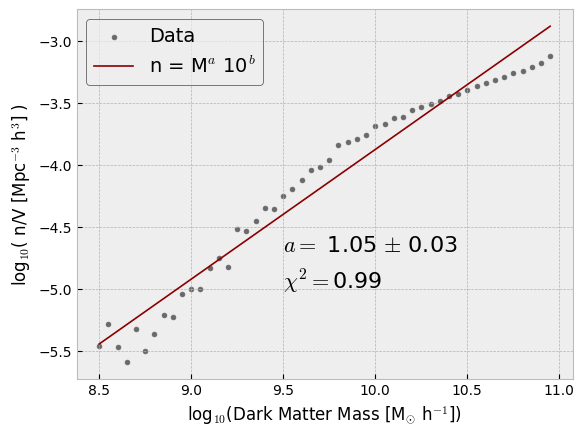

El exponente corresponde a la pendiente de una recta, en una escala logaritmica. Su valor es de: 1.05 +- 0.03


In [140]:
#realizamos el ajuste y luego graficamos la recta que se genera al estar en logaritmo (por la power law)
res_power_law, cov_power_law = curve_fit(power_law, x_log, y_log) #aplicamos curve_fit
exp, coef = res_power_law #tomamos los valores de los parámetros 
err_exp = (cov_power_law[0,0])**(1/2) #error del exponente

y_fit = power_law(x_log, exp, coef) #Ajustamos para masas menores y vemos que dacae bien fuerte para masas menores

chi_squared = np.sum( ((y_log - y_fit)**2)/y_log )
chi_squared_red = 10**((1/( len(y_fit) - 2 )) * chi_squared)

plt.scatter(x_log, y_log, color ='dimgray', s = 12, label = 'Data')
plt.plot(x_log, y_fit, lw = 1.2, ls = '-', color = 'darkred', label = 'n = M$^{a}$ 10$^{b}$')

plt.xlabel(r'log$_{10}$(Dark Matter Mass [M$_{\odot}$ h$^{-1}$])')
plt.ylabel(r'log$_{10}$( n/V [Mpc$^{-3}$ h$^3$] )')

plt.text(9.5, -4.7, '$a =$ '+str(round(exp, 2))+ r' $\pm$ '+str(round(err_exp,2)), fontsize = 16 )
plt.text(9.5, -5, r'$\chi^{2} = $'+str(round(chi_squared_red, 2)),  fontsize = 16)

plt.legend(fontsize = 14, edgecolor = (0,0,0,1), framealpha = .7)

plt.savefig('imagenes/preg2/Halo_Mass_Func_FTI.png', dpi = 600)
plt.show()

print(f'El exponente corresponde a la pendiente de una recta, en una escala logaritmica. Su valor es de: {round(exp, 2)}'+f' +- {round(err_exp,2)}')

In [19]:
#Podríamos decir que existe este drop hacia halos menos masivos, debido a que TNG300 es una simulación que abarca grandes distancias, por lo que es más probable tener halos más masivos.

In [20]:
#El limite es 5.9 *10**7 para masa estelar (log(7.77 [M_sun / h]))

In [21]:
#más galaxias centrales, se pierden galaxias satélite 

In [141]:
# Luminosity Function
little_h_TNG = 	0.6774

In [142]:
#number density para la banda g
g_band_LF = g_band - 5*np.log10(little_h_TNG)
hist_LF_g_band, bins_LF_g_band = np.histogram(g_band_LF, bins = 40)
mag_LF_g_band = bins_LF_g_band[:-10]
num_dens_LF_g_band = hist_LF_g_band[:-9]/vol_box_sim

#number density para la banda r
r_band_LF = r_band - 5*np.log10(little_h_TNG)
hist_LF_r_band, bins_LF_r_band = np.histogram(r_band_LF, bins = 40)
mag_LF_r_band = bins_LF_r_band[:-10]
num_dens_LF_r_band = hist_LF_r_band[:-9]/vol_box_sim

#number density para la banda i
i_band_LF = i_band - 5*np.log10(little_h_TNG)
hist_LF_i_band, bins_LF_i_band = np.histogram(i_band_LF, bins = 40)
mag_LF_i_band = bins_LF_i_band[:-10]
num_dens_LF_i_band = hist_LF_i_band[:-9]/vol_box_sim

#number density para la banda z
z_band_LF = z_band - 5*np.log10(little_h_TNG)
hist_LF_z_band, bins_LF_z_band = np.histogram(z_band_LF, bins = 40)
mag_LF_z_band = bins_LF_z_band[:-10]
num_dens_LF_z_band = hist_LF_z_band[:-9]/vol_box_sim

In [143]:
print(np.log10(num_dens_LF_g_band))

[-6.63423159 -6.93526158 -6.33320159 -6.15711033 -5.75917032 -5.40378267
 -5.35547799 -4.99077891 -4.88218314 -4.71254511 -4.53558786 -4.33537851
 -4.19175182 -3.94848985 -3.71830438 -3.48041672 -3.25365858 -3.07726609
 -2.92086707 -2.81121406 -2.72010007 -2.6734042  -2.65252621 -2.65598258
 -2.67238353 -2.66649646 -2.65076317 -2.64128063 -2.64438148 -2.65406908
 -2.68706755]


In [144]:
def Schechter_function(x, phi_const, M_const, alpha_const):
    y = phi_const * 0.4*np.log(10) * ( 10**(0.4*(M_const - x)*(alpha_const + 1)) ) * np.exp( -10**(0.4*(M_const - x)) )
    return y

In [145]:
#para la banda g
res, cov = curve_fit(Schechter_function, mag_LF_g_band, num_dens_LF_g_band, maxfev = 1000000, p0 = [-1.785, -19.67, -1.21])
param_phi_g, param_mag_g, param_alpha_g = res
err_phi_g, err_mag_g, err_alpha_g = (cov[0,0])**(1/2), (cov[1,1])**(1/2), (cov[2,2])**(1/2)
y_fit = Schechter_function(mag_LF_g_band, *res)
chi_cuad_red_g = (1/( len(mag_LF_r_band) - 3 ) * np.sum( (num_dens_LF_g_band - y_fit)**2 / num_dens_LF_g_band))

#para la banda r
res_r, cov_r = curve_fit(Schechter_function, mag_LF_r_band, num_dens_LF_r_band, maxfev = 1000000, p0 = [-1.785, -20.67, -1.21])
param_phi_r, param_mag_r, param_alpha_r = res_r
err_phi_r, err_mag_r, err_alpha_r = (cov_r[0,0])**(1/2), (cov_r[1,1])**(1/2), (cov_r[2,2])**(1/2)
y_fit_r = Schechter_function(mag_LF_r_band, *res_r)
chi_cuad_red_r = (1/( len(mag_LF_r_band) - 3 ) * np.sum( (num_dens_LF_r_band - y_fit_r)**2 / num_dens_LF_r_band))

#para la banda i
res_i, cov_i = curve_fit(Schechter_function, mag_LF_i_band, num_dens_LF_i_band, maxfev = 1000000, p0 = [-1.785, -20.87, -1.21])
param_phi_i, param_mag_i, param_alpha_i = res_i
err_phi_i, err_mag_i, err_alpha_i = (cov_i[0,0])**(1/2), (cov_i[1,1])**(1/2), (cov_i[2,2])**(1/2)
y_fit_i = Schechter_function(mag_LF_i_band, *res_i)
chi_cuad_red_i = (1/( len(mag_LF_i_band) - 3 ) * np.sum( (num_dens_LF_i_band - y_fit_i)**2 / num_dens_LF_i_band))

#para la banda z
res_z, cov_z = curve_fit(Schechter_function, mag_LF_z_band, num_dens_LF_z_band, maxfev = 1000000, p0 = [-1.785, -21.67, -1.5])
param_phi_z, param_mag_z, param_alpha_z = res_z
err_phi_z, err_mag_z, err_alpha_z = (cov_z[0,0])**(1/2), (cov_z[1,1])**(1/2), (cov_z[2,2])**(1/2)
y_fit_z = Schechter_function(mag_LF_z_band, *res_z)
chi_cuad_red_z = (1/( len(mag_LF_z_band) - 3 ) * np.sum( (num_dens_LF_z_band - y_fit_z)**2 / num_dens_LF_z_band))

7.844165088628403e-06
1.0871329687621292e-05
1.1209792667781415e-05
1.1244676973402443e-05


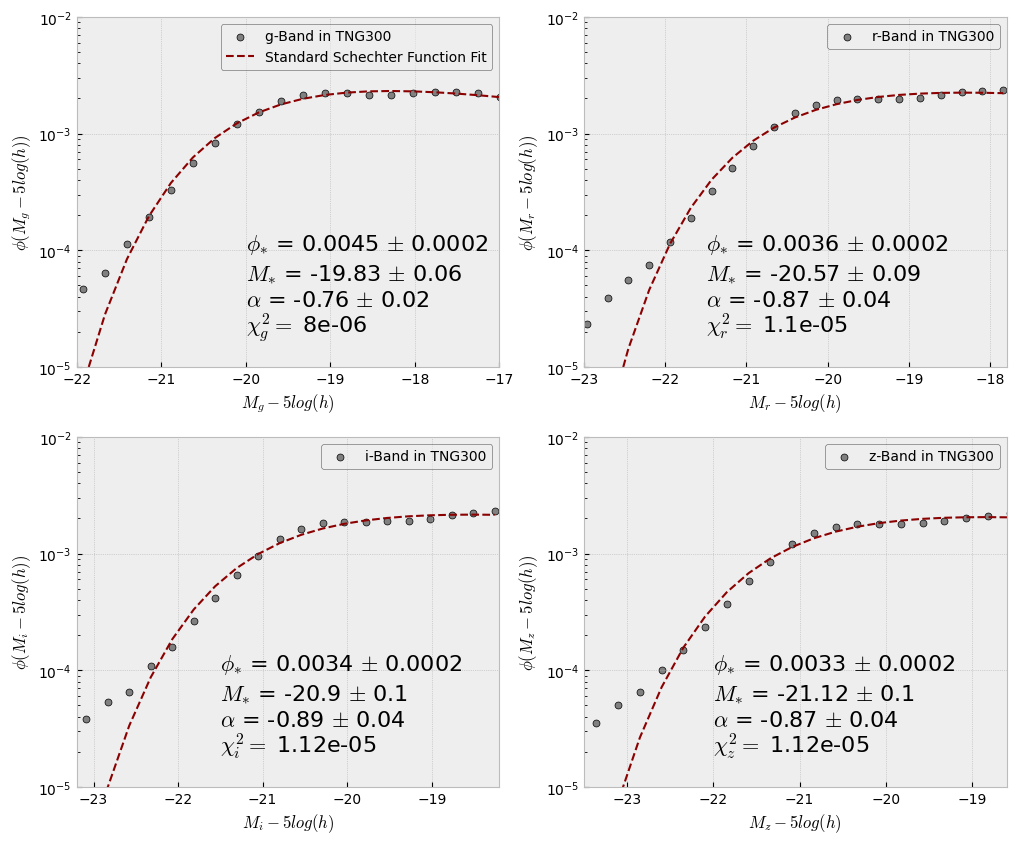

In [146]:
#para la banda g
fig = plt.figure(figsize = (12,10))
ax = fig.subplots(2,2)

ax[0,0].scatter(mag_LF_g_band, num_dens_LF_g_band, color ='gray', edgecolor='black', s = 25, label = 'g-Band in TNG300')
ax[0,0].plot(mag_LF_g_band, y_fit, color = 'darkred', label = 'Standard Schechter Function Fit', lw = 1.5, ls = '--')

ax[0,0].set_xlabel(r'$M_{g} - 5log(h)$')
ax[0,0].set_ylabel(r'$\phi( M_{g} - 5log(h) )$')

ax[0,0].legend(edgecolor = (0,0,0,1), framealpha = .5)
ax[0,0].grid(lw = .5, ls = ':')
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(-22,-17)
ax[0,0].set_ylim(10**(-5), 10**(-2))
ax[0,0].text(-20, 10**(-4), r'$\phi_{*}$ = '+str(round(param_phi_g, 4))+' $\pm$ '+str(round(err_phi_g, 4)), fontsize = 16)
ax[0,0].text(-20, 10**(-4.25), r'$M_{*}$ = '+str(round(param_mag_g, 2))+' $\pm$ '+str(round(err_mag_g, 2)), fontsize = 16)
ax[0,0].text(-20, 10**(-4.48), r'$\alpha$ = '+str(round(param_alpha_g, 2))+' $\pm$ '+str(round(err_alpha_g, 2)), fontsize = 16)
ax[0,0].text(-20, 10**(-4.7), r'$\chi^{2}_{g} = $ '+str(round(chi_cuad_red_g, 6)), fontsize = 16)

#para la banda r
ax[0,1].scatter(mag_LF_r_band, num_dens_LF_r_band, color ='gray', edgecolor='black', s = 25, label = 'r-Band in TNG300')
ax[0,1].plot(mag_LF_r_band, y_fit_r, color = 'darkred', lw = 1.5, ls = '--')

ax[0,1].set_xlabel(r'$M_{r} - 5log(h)$')
ax[0,1].set_ylabel(r'$\phi( M_{r} - 5log(h) )$')

ax[0,1].legend(edgecolor = (0,0,0,1), framealpha = .5)
ax[0,1].grid(lw = .5, ls = ':')
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(-23,-17.8)
ax[0,1].set_ylim(10**(-5), 10**(-2))
ax[0,1].text(-21.5, 10**(-4), r'$\phi_{*}$ = '+str(round(param_phi_r, 4))+' $\pm$ '+str(round(err_phi_r, 4)), fontsize = 16)
ax[0,1].text(-21.5, 10**(-4.25), r'$M_{*}$ = '+str(round(param_mag_r, 2))+' $\pm$ '+str(round(err_mag_r, 2)), fontsize = 16)
ax[0,1].text(-21.5, 10**(-4.48), r'$\alpha$ = '+str(round(param_alpha_r, 2))+' $\pm$ '+str(round(err_alpha_r, 2)), fontsize = 16)
ax[0,1].text(-21.5, 10**(-4.7), r'$\chi^{2}_{r} = $ '+str(round(chi_cuad_red_r, 6)), fontsize = 16)

#para la banda i
ax[1,0].scatter(mag_LF_i_band, num_dens_LF_i_band, color ='gray', edgecolor='black', s = 25, label = 'i-Band in TNG300')
ax[1,0].plot(mag_LF_i_band, y_fit_i, color = 'darkred', lw = 1.5, ls = '--')

ax[1,0].set_xlabel(r'$M_{i} - 5log(h)$')
ax[1,0].set_ylabel(r'$\phi( M_{i} - 5log(h) )$')

ax[1,0].legend(edgecolor = (0,0,0,1), framealpha = .5)
ax[1,0].grid(lw = .5, ls = ':')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(-23.2,-18.2)
ax[1,0].set_ylim(10**(-5), 10**(-2))
ax[1,0].text(-21.5, 10**(-4), r'$\phi_{*}$ = '+str(round(param_phi_i, 4))+' $\pm$ '+str(round(err_phi_i, 4)), fontsize = 16)
ax[1,0].text(-21.5, 10**(-4.25), r'$M_{*}$ = '+str(round(param_mag_i, 2))+' $\pm$ '+str(round(err_mag_i, 2)), fontsize = 16)
ax[1,0].text(-21.5, 10**(-4.48), r'$\alpha$ = '+str(round(param_alpha_i, 2))+' $\pm$ '+str(round(err_alpha_i, 2)), fontsize = 16)
ax[1,0].text(-21.5, 10**(-4.7), r'$\chi^{2}_{i} = $ '+str(round(chi_cuad_red_i, 7)), fontsize = 16)

#para la banda z
ax[1,1].scatter(mag_LF_z_band, num_dens_LF_z_band, color ='gray', edgecolor='black', s = 25, label = 'z-Band in TNG300')
ax[1,1].plot(mag_LF_z_band, y_fit_z, color = 'darkred', lw = 1.5, ls = '--')

ax[1,1].set_xlabel(r'$M_{z} - 5log(h)$')
ax[1,1].set_ylabel(r'$\phi( M_{z} - 5log(h) )$')

ax[1,1].legend(edgecolor = (0,0,0,1), framealpha = .5)
ax[1,1].grid(lw = .5, ls = ':')
ax[1,1].set_yscale('log')
ax[1,1].set_xlim(-23.5,-18.6)
ax[1,1].set_ylim(10**(-5), 10**(-2))
ax[1,1].text(-22, 10**(-4), r'$\phi_{*}$ = '+str(round(param_phi_z, 4))+' $\pm$ '+str(round(err_phi_z, 4)), fontsize = 16)
ax[1,1].text(-22, 10**(-4.25), r'$M_{*}$ = '+str(round(param_mag_z, 2))+' $\pm$ '+str(round(err_mag_z, 2)), fontsize = 16)
ax[1,1].text(-22, 10**(-4.48), r'$\alpha$ = '+str(round(param_alpha_z, 2))+' $\pm$ '+str(round(err_alpha_z, 2)), fontsize = 16)
ax[1,1].text(-22, 10**(-4.7), r'$\chi^{2}_{z} = $ '+str(round(chi_cuad_red_z, 7)), fontsize = 16)

fig.savefig('imagenes/preg3/lum_func_fit_per_bands.png', dpi = 600)
plt.show()

In [147]:
#number density para la banda g (RED SEQUENCE)
g_band_LF_RS = g_band[pos_no_sforming] - 5*np.log10(little_h_TNG)
hist_LF_g_band_RS, bins_LF_g_band_RS = np.histogram(g_band_LF_RS, bins = 40)
mag_LF_g_band_RS = bins_LF_g_band_RS[:-10]
num_dens_LF_g_band_RS = hist_LF_g_band_RS[:-9]/vol_box_sim

#number density para la banda g (BLUE CLOUD)
g_band_LF_BC = g_band[pos_sforming] - 5*np.log10(little_h_TNG)
hist_LF_g_band_BC, bins_LF_g_band_BC = np.histogram(g_band_LF_BC, bins = 40)
mag_LF_g_band_BC = bins_LF_g_band_BC[:-10]
num_dens_LF_g_band_BC = hist_LF_g_band_BC[:-9]/vol_box_sim

In [148]:
#para la banda g (RED SEQUENCE)
res_RS, cov_RS = curve_fit(Schechter_function, mag_LF_g_band_RS, num_dens_LF_g_band_RS, maxfev = 1000000, p0 = [-1.785, -20.67, -1.21])
param_phi_g_RS, param_mag_g_RS, param_alpha_g_RS = res_RS
err_phi_g_RS, err_mag_g_RS, err_alpha_g_RS = (cov_RS[0,0])**(1/2), (cov_RS[1,1])**(1/2), (cov_RS[2,2])**(1/2)
y_fit_RS = Schechter_function(mag_LF_g_band_RS, *res_RS)
chi_cuad_red_g_RS = (1/( len(num_dens_LF_g_band_RS) - 3 ) * np.sum( (num_dens_LF_g_band_RS - y_fit_RS)**2 / num_dens_LF_g_band_RS))

#para la banda g (BLUE CLOUD)
res_BC, cov_BC = curve_fit(Schechter_function, mag_LF_g_band_BC, num_dens_LF_g_band_BC, maxfev = 1000000, p0 = [-1.785, -19.67, -1.21])
param_phi_g_BC, param_mag_g_BC, param_alpha_g_BC = res_BC
err_phi_g_BC, err_mag_g_BC, err_alpha_g_BC = (cov_BC[0,0])**(1/2), (cov_BC[1,1])**(1/2), (cov_BC[2,2])**(1/2)
y_fit_BC = Schechter_function(mag_LF_g_band_BC, *res_BC)
chi_cuad_red_g_BC = (1/( len(num_dens_LF_g_band_BC) - 3 ) * np.sum( (num_dens_LF_g_band_BC - y_fit_BC)**2 / num_dens_LF_g_band_BC))

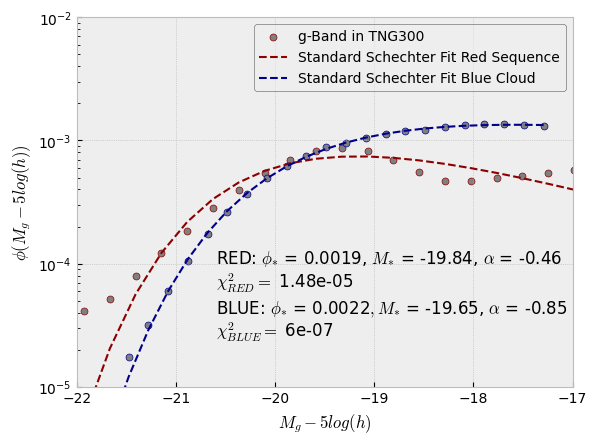

In [149]:
#para la banda g
fig = plt.figure(figsize = (6.4,4.8))
ax = fig.subplots()

ax.scatter(mag_LF_g_band_RS, num_dens_LF_g_band_RS, color ='gray', edgecolor='darkred', s = 25, label = 'g-Band in TNG300')
ax.plot(mag_LF_g_band_RS, y_fit_RS, color = 'darkred', label = 'Standard Schechter Fit Red Sequence', lw = 1.5, ls = '--')

ax.scatter(mag_LF_g_band_BC, num_dens_LF_g_band_BC, color ='gray', edgecolor='darkblue', s = 25)
ax.plot(mag_LF_g_band_BC, y_fit_BC, color = 'darkblue', label = 'Standard Schechter Fit Blue Cloud', lw = 1.5, ls = '--')

ax.set_xlabel(r'$M_{g} - 5log(h)$')
ax.set_ylabel(r'$\phi( M_{g} - 5log(h) )$')

ax.legend(edgecolor = (0,0,0,1), framealpha = .5)
ax.grid(lw = .5, ls = ':')
ax.set_yscale('log')
ax.set_xlim(-22,-17)
ax.set_ylim(10**(-5), 10**(-2))
ax.text(-20.6, 10**(-4), r'RED: $\phi_{*}$ = '+str(round(param_phi_g_RS, 4))+r', $M_{*}$ = '+str(round(param_mag_g_RS, 2))+ r', $\alpha$ = '+str(round(param_alpha_g_RS, 2)), fontsize = 12)
ax.text(-20.6, 10**(-4.4), r'BLUE: $\phi_{*}$ = '+str(round(param_phi_g_BC, 4))+r'$, M_{*}$ = '+str(round(param_mag_g_BC, 2))+ r', $\alpha$ = '+str(round(param_alpha_g_BC, 2)), fontsize = 12)
ax.text(-20.6, 10**(-4.2), r'$\chi^{2}_{RED} = $ '+str(round(chi_cuad_red_g_RS, 7)), fontsize = 12)
ax.text(-20.6, 10**(-4.6), r'$\chi^{2}_{BLUE} = $ '+str(round(chi_cuad_red_g_BC, 7)), fontsize = 12)

fig.savefig('imagenes/preg3/lum_func_fit_per_BLUE_RED.png', dpi = 600)
plt.show()

In [150]:
#Para la parte del environment (pregunta 5)
'''n_prom = len(posx)/205**3
radius = np.array([3,5]) #unidades de Mpc'''

'n_prom = len(posx)/205**3\nradius = np.array([3,5]) #unidades de Mpc'

In [151]:
'''def num_dens_for_gal(rad, posx, posy, posz, pos_x_gal, pos_y_gal, pos_z_gal):
    vol_esf = (4/3) * np.pi * rad**3
    dist = np.sqrt( (pos_x_gal - posx)**2 + (pos_y_gal - posy)**2 + (pos_z_gal - posz)**2 )
    galaxies_in_rad = np.where(dist <= rad)[0]
    cant_gal = len(galaxies_in_rad)
    number_dens_for_gal = cant_gal/vol_esf
    return number_dens_for_gal
    
def over_dens(n, n_promedio):
    delta = (n - n_promedio) / n_promedio
    return delta'''

'def num_dens_for_gal(rad, posx, posy, posz, pos_x_gal, pos_y_gal, pos_z_gal):\n    vol_esf = (4/3) * np.pi * rad**3\n    dist = np.sqrt( (pos_x_gal - posx)**2 + (pos_y_gal - posy)**2 + (pos_z_gal - posz)**2 )\n    galaxies_in_rad = np.where(dist <= rad)[0]\n    cant_gal = len(galaxies_in_rad)\n    number_dens_for_gal = cant_gal/vol_esf\n    return number_dens_for_gal\n    \ndef over_dens(n, n_promedio):\n    delta = (n - n_promedio) / n_promedio\n    return delta'

In [152]:
'''overdensity_list = [] 
for r in radius:
    overdensity_list_rad = []
    for i in tqdm(range(0, len(posx)), 'Procesando: '):
        galaxy_posx, galaxy_posy, galaxy_posz = posx[i], posy[i], posz[i]
        delta = over_dens(num_dens_for_gal(r, posx, posy, posz, galaxy_posx, galaxy_posy, galaxy_posz), n_prom)
        overdensity_list_rad.append(delta)
    overdensity_list.append(overdensity_list_rad)
overdensity_3r, overdensity_5r = np.array(overdensity_list)[0], np.array(overdensity_list)[1]'''

"overdensity_list = [] \nfor r in radius:\n    overdensity_list_rad = []\n    for i in tqdm(range(0, len(posx)), 'Procesando: '):\n        galaxy_posx, galaxy_posy, galaxy_posz = posx[i], posy[i], posz[i]\n        delta = over_dens(num_dens_for_gal(r, posx, posy, posz, galaxy_posx, galaxy_posy, galaxy_posz), n_prom)\n        overdensity_list_rad.append(delta)\n    overdensity_list.append(overdensity_list_rad)\noverdensity_3r, overdensity_5r = np.array(overdensity_list)[0], np.array(overdensity_list)[1]"

In [153]:
overdensity_3r = np.load('overdensity_3r.npy')
overdensity_5r = np.load('overdensity_5r.npy')

In [154]:
print(overdensity_3r)
print('--------------------------')
print(overdensity_5r)
print('--------------------------')
print(len(overdensity_3r))
print('--------------------------')
print(len(overdensity_5r))
print('--------------------------')
print(len(stellar_mass))
print('--------------------------')

[147.66254042 135.1031189  157.40249996 ...  29.50145226  22.83726941
  11.55942152]
--------------------------
[55.30516824 60.56474639 56.41244785 ... 10.51570796  5.80976961
  3.76130233]
--------------------------
297191
--------------------------
297191
--------------------------
297191
--------------------------


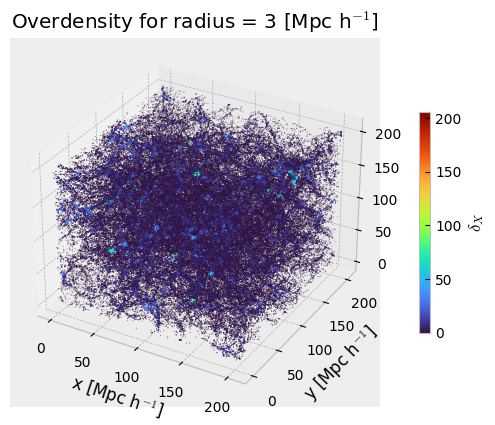

In [175]:
fig = plt.figure(figsize=(6.4, 4.8))

ax1 = fig.add_subplot(projection='3d')
im1 = ax1.scatter(posx, posy, posz, s=0.05, c=overdensity_3r, cmap='turbo')
cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.6, aspect=20, pad=0.08, label = r'$\delta_{X}$')
ax1.set_title('Overdensity for radius = 3 [Mpc h$^{-1}$]')
ax1.set_xlabel('x [Mpc h$^{-1}$]')
ax1.set_ylabel('y [Mpc h$^{-1}$]')

fig.savefig('imagenes/preg5/overdens_cubic_3r.png', dpi = 600)
plt.show()

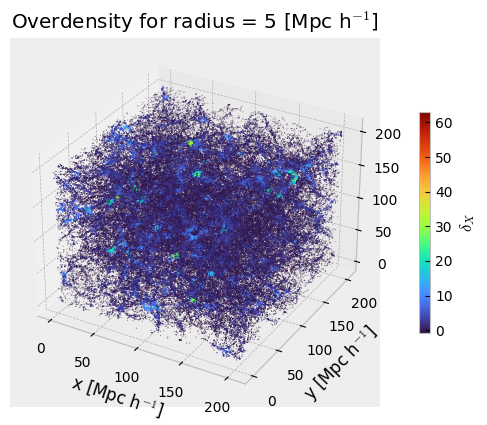

In [176]:
fig = plt.figure(figsize=(6.4, 4.8))

ax2 = fig.add_subplot(projection='3d')
im2 = ax2.scatter(posx, posy, posz, s=0.05, c=overdensity_5r, cmap='turbo')
cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.6, aspect=20, pad=0.08, label = r'$\delta_{X}$')
ax2.set_title('Overdensity for radius = 5 [Mpc h$^{-1}$]')
ax2.set_xlabel('x [Mpc h$^{-1}$]')
ax2.set_ylabel('y [Mpc h$^{-1}$]')

fig.savefig('imagenes/preg5/overdens_cubic_5r.png', dpi = 600)
plt.show()

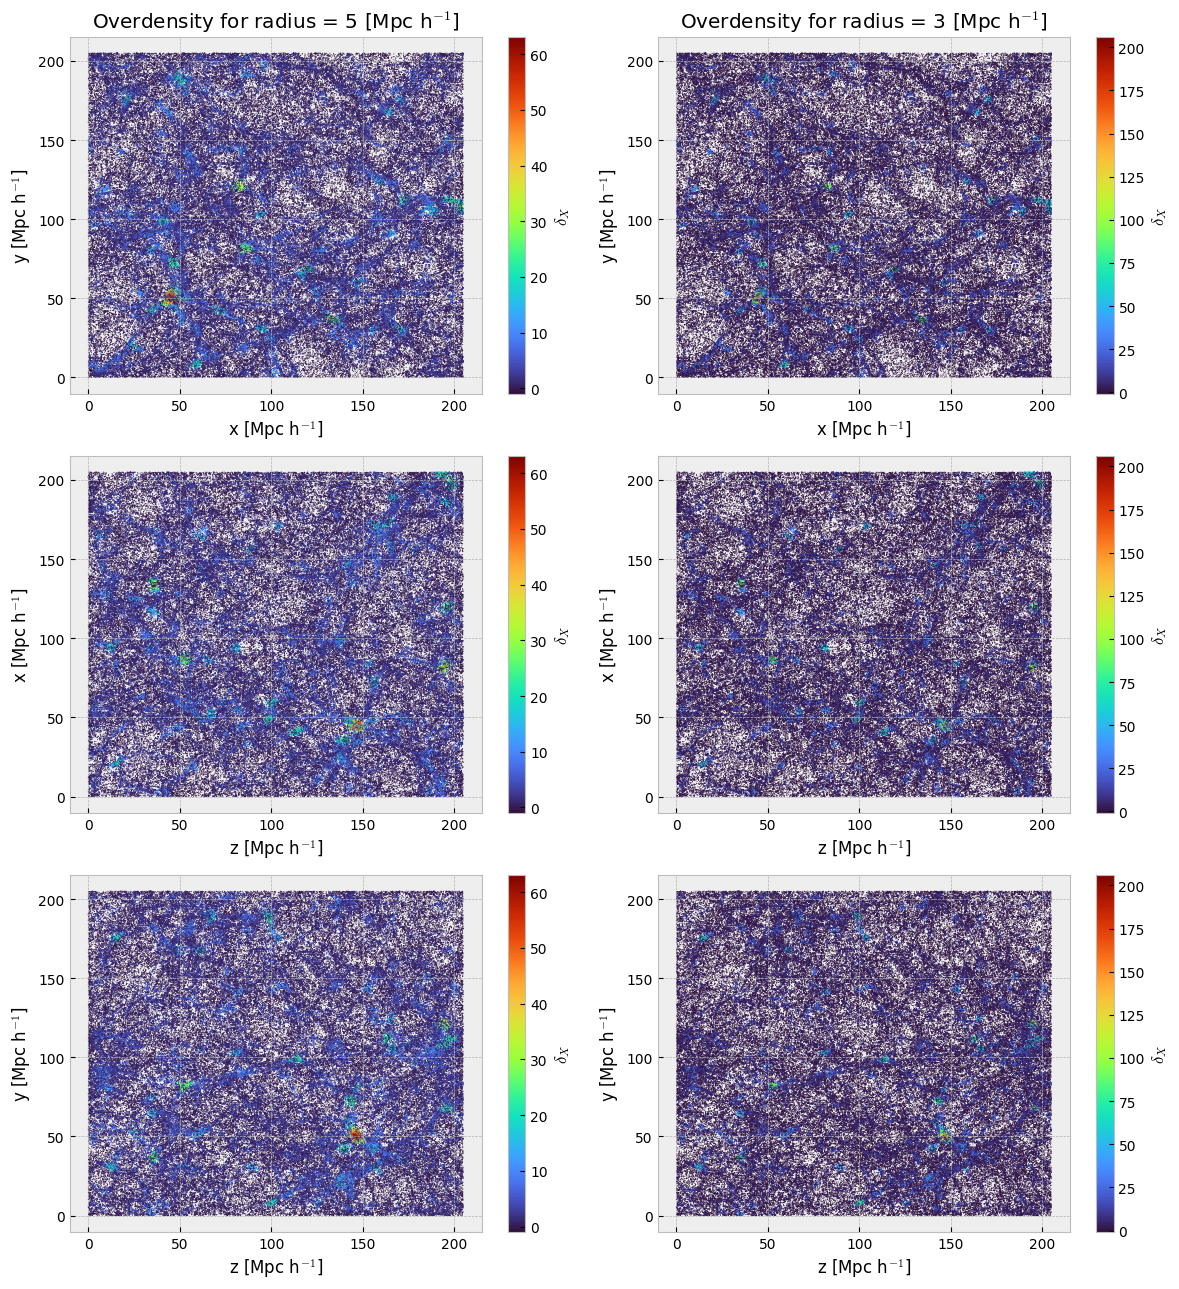

In [157]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12, 13))

graf1 = axes[0, 0].scatter(posx, posy, s=0.05, c=overdensity_5r, cmap='turbo')
cbar1 = plt.colorbar(graf1, ax=axes[0, 0], label=r'$\delta_{X}$')
axes[0, 0].set_title('Overdensity for radius = 5 [Mpc h$^{-1}$]')
axes[0, 0].set_xlabel('x [Mpc h$^{-1}$]')
axes[0, 0].set_ylabel('y [Mpc h$^{-1}$]')

graf2 = axes[0, 1].scatter(posx, posy, s=0.05, c=overdensity_3r, cmap='turbo')
cbar2 = plt.colorbar(graf2, ax=axes[0, 1], label=r'$\delta_{X}$')
axes[0, 1].set_title('Overdensity for radius = 3 [Mpc h$^{-1}$]')
axes[0, 1].set_xlabel('x [Mpc h$^{-1}$]')
axes[0, 1].set_ylabel('y [Mpc h$^{-1}$]')

graf3 = axes[1, 0].scatter(posz, posx, s=0.05, c=overdensity_5r, cmap='turbo')
cbar3 = plt.colorbar(graf3, ax=axes[1, 0], label=r'$\delta_{X}$')
axes[1, 0].set_xlabel('z [Mpc h$^{-1}$]')
axes[1, 0].set_ylabel('x [Mpc h$^{-1}$]')

graf4 = axes[1, 1].scatter(posz, posx, s=0.05, c=overdensity_3r, cmap='turbo')
cbar4 = plt.colorbar(graf4, ax=axes[1, 1], label=r'$\delta_{X}$')
axes[1, 1].set_xlabel('z [Mpc h$^{-1}$]')
axes[1, 1].set_ylabel('x [Mpc h$^{-1}$]')

graf5 = axes[2, 0].scatter(posz, posy, s=0.05, c=overdensity_5r, cmap='turbo')
cbar5 = plt.colorbar(graf5, ax=axes[2, 0], label=r'$\delta_{X}$')
axes[2, 0].set_xlabel('z [Mpc h$^{-1}$]')
axes[2, 0].set_ylabel('y [Mpc h$^{-1}$]')

graf6 = axes[2, 1].scatter(posz, posy, s=0.05, c=overdensity_3r, cmap='turbo')
cbar6 = plt.colorbar(graf6, ax=axes[2, 1], label=r'$\delta_{X}$')
axes[2, 1].set_xlabel('z [Mpc h$^{-1}$]')
axes[2, 1].set_ylabel('y [Mpc h$^{-1}$]')

plt.tight_layout()
fig.savefig('imagenes/preg5/overdens_2D.png', dpi = 500)
plt.show()